# Rift delineation using Random Forest

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify each point along an ICESat-2 track based on whether or not that point lies within a rift. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 10 #choose the number of decision trees

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

and set paths as necessary.

In [3]:
root_path = '/data/fast1/rift-id/'
outputs_path = root_path + 'outputs' #where the training data are stored

## Step 1: Load all relevant datasets

We'll load elevation profiles for each track and normalize each elevation profile by its maximal value. Meanwhile, we'll also load label arrays which label each point along each track as either "within a rift" (1) or "not within a rift" (0). These data will be used to together to train the rift delineation model.

In [4]:
training_data_1 = pd.read_pickle(outputs_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice

#elevation profiles are used for training the first model
elevation_profiles = training_data_1['h_subset'] #surface elevations along each track
elevation_profiles_1 = np.array([profile/np.max(profile) for profile in elevation_profiles]) #where '1' indicates rifted ice

#point labels are used for training the second model
labels = training_data_1['bin_subset']
labels_1 = np.array([label for label in labels]) #to ensure labels_1 has the same shape as elevation_profiles_1

#concatinate the training data
elevation_profiles = np.concatenate([elevation_profiles_1]) #concatenate all surface elevation profiles
labels = np.concatenate([labels_1])

### Modify the data 

In the loaded data, all training tracks have the rift positioned at the track center. However, this does not reflect real-world conditions, where rifts may appear at arbitrary locations (and generally, not all tracks will contain rifts). To improve the model's ability to detect rifts at any position along the track, we will modify the training data. Each track will be cropped to start and end at randomly-selected indices, so that the result may or may not contain a rift, and most rifts will generally not occur at the centre of the domain. We then resample the cropped tracks back to their original number of points.

In [5]:
elevation_profiles_cropped = []
labels_cropped = []

n = len(elevation_profiles[0])
centre_index = int(n/2)

for i in range(len(elevation_profiles)):
    for j in range(10): #in fact, why not do this many times just to increase the training sample?
        start_index = np.random.randint(n - 1) #start anywhere less than n
        end_index = np.random.randint(start_index + 1, high = n) #end anywhere between start_index and n
        
        temp_profile = elevation_profiles[i][start_index:end_index]
        temp_profile = resample(temp_profile, n)
        elevation_profiles_cropped.append(np.array(temp_profile))
        
        temp_label = labels[i][start_index:end_index]
        temp_label = resample(temp_label, n)
        labels_cropped.append(np.rint(np.array(temp_label))) #np.rint to ensure we don't end up with non-binary values

In [12]:
count = sum(1 in entry for entry in labels_cropped)
print(f'{count/len(labels_cropped)*100:.2f}% of cropped tracks contain rifts')

46.36% of cropped tracks contain rifts


## Step 2: Train the model

In [7]:
training_data = {
    'features': elevation_profiles_cropped,
    'labels': labels_cropped
}

X_train, X_test, Y_train, Y_test = train_test_split(training_data['features'], training_data['labels'], 
                                                    test_size = 0.1, random_state=0)
model = RandomForestClassifier(n_estimators = trees)
model.fit(X_train, Y_train)
score = model.score(X_test,Y_test)
print(f'model score: {100*score : 0.2f}%')

model score:  51.14%


## Step 3: Test the model

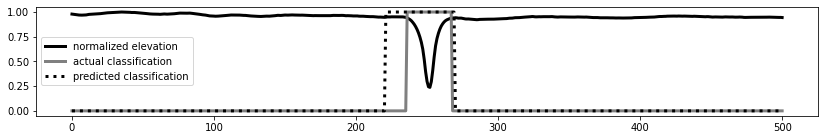

In [11]:
index = 0 #choose a track to feed into the model
input_track = np.array([elevation_profiles_1[index]])
actual_labels = np.array([labels_1[index]]) #the actual labels along that track
predicted_labels = model.predict(input_track) #the predicted labels along that track

plt.figure(figsize = (14, 2))
plt.plot(input_track[0], color = '0', linewidth = 3, label = 'normalized elevation')
plt.plot(actual_labels[0], color = '0.5', linewidth = 3, label = 'actual classification')
plt.plot(predicted_labels[0], color = '0', linewidth = 3, linestyle = 'dotted', label = 'predicted classification')
# plt.plot(actual_labels[0] - predicted_labels[0], color = 'blue', label = 'misfit')
plt.legend(loc = 'center left')